<a href="https://colab.research.google.com/github/ashishpatel26/Image-Classification-on-SVHN-dataset/blob/master/Image_Classification_on_SVHN_dataset_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classifier for the SVHN dataset
### Introduction

SVHN is a real-world image dataset for developing machine learning and object recognition algorithms with minimal requirement on data preprocessing and formatting. It can be seen as similar in flavor to MNIST (e.g., the images are of small cropped digits), but incorporates an order of magnitude more labeled data (over 600,000 digit images) and comes from a significantly harder, unsolved, real world problem (recognizing digits and numbers in natural scene images). SVHN is obtained from house numbers in Google Street View images.

Official Dataset : [Dataset](http://ufldl.stanford.edu/housenumbers/)

Importing libraries

In [0]:
import tensorflow as tf
from scipy.io import loadmat
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Flatten

To downlaod Training dataset

In [2]:
!wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat

--2020-05-27 06:32:28--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  56.4MB/s    in 3.6s    

2020-05-27 06:32:32 (47.6 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]



To downlaod Testing dataset

In [3]:
!wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2020-05-27 06:32:38--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  12.5MB/s    in 5.0s    

2020-05-27 06:32:44 (12.2 MB/s) - ‘test_32x32.mat’ saved [64275384/64275384]



Checking that the files are downloaded

In [4]:
!ls -lh 

total 235M
drwxr-xr-x 1 root root 4.0K May 13 16:29 sample_data
-rw-r--r-- 1 root root  62M Dec  6  2011 test_32x32.mat
-rw-r--r-- 1 root root 174M Dec  6  2011 train_32x32.mat


In [0]:
# Load the dataset
def load_data():
    train = loadmat('train_32x32.mat')
    test = loadmat('test_32x32.mat')

    return train, test

train, test = load_data()

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Preprocess Dataset


In [0]:
import numpy as np

def transpose_images(images):
    # transposing the image arrays
    imgs = images["X"]
    imgs = np.transpose(imgs, (3, 0, 1, 2))
    labels = images["y"]

    return imgs, labels

In [0]:
train_images, train_labels = transpose_images(train)
test_images, test_labels = transpose_images(test)

Printing the shapes of all data

In [8]:
print(f"Training image set : {train_images.shape}")
print(f"Testing image set : {test_images.shape}")
print('\n')
print(f"Total images : {train_images.shape[0] + test_images.shape[0]}")

Training image set : (73257, 32, 32, 3)
Testing image set : (26032, 32, 32, 3)


Total images : 99289


Defining function to plot image samples

In [0]:
def plot_images(img, labels, rows=2, cols=5):
    # Plot rows x cols images
    fig, axes = plt.subplots(rows, cols)
    for i, axis in enumerate(axes.flat):
        # For plotting RGB images
        if img[i].shape == (32, 32, 3):
            axis.imshow(img[i])
        # For plotting Grayscale images by removing last dimension (color)
        else:
            axis.imshow(img[i,:,:,0])
        axis.set_xticks([])
        axis.set_yticks([])
        axis.set_title(labels[i])

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


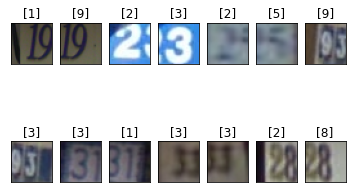

In [10]:
# Plotting training images
plot_images(train_images, train_labels,2, 7)

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


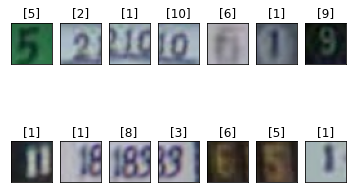

In [11]:
# Plotting testing images
plot_images(test_images, test_labels, 2, 7)

In [12]:
# To know all unique labels present in dataset
print(np.unique(train_labels))

[ 1  2  3  4  5  6  7  8  9 10]


In [13]:
# Converting label 10 to 0 in labels dataset
train_labels[train_labels == 10] = 0
test_labels[test_labels == 10] = 0
print(np.unique(train_labels))

[0 1 2 3 4 5 6 7 8 9]


Converting RGB images to Grayscale

In [0]:
# To convert rgb to gray images with formula Gray = (0.2990R + 0.5870G + 0.1140B)
def convert_to_gray(images):
    return np.expand_dims(np.dot(images, [0.2990, 0.5870, 0.1140]), axis=3)

In [0]:
train_grayscale = convert_to_gray(train_images).astype(np.float32)
test_grayscale = convert_to_gray(test_images).astype(np.float32)

PLotting Grayscale images

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


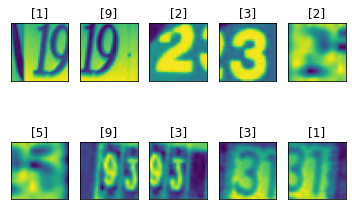

In [16]:
# Ploting the Grayscale Image
plot_images(train_grayscale, train_labels)

Creating validation split from training dataset

In [0]:
# To create a validation set of 10% from training set
from sklearn.model_selection import train_test_split

train_grayscale, val_grayscale, train_labels, val_labels = train_test_split(train_grayscale, train_labels, test_size=0.10)

In [18]:
# Printing new shapes of all datasets
print("Training Images Set", train_grayscale.shape)
print("Training Label Set", train_labels.shape)
print("Testing Images Set", test_grayscale.shape)
print("Testing Label Set", test_labels.shape)
print("Validation Images Set", val_grayscale.shape)
print("Validation Label Set", val_labels.shape)

Training Images Set (65931, 32, 32, 1)
Training Label Set (65931, 1)
Testing Images Set (26032, 32, 32, 1)
Testing Label Set (26032, 1)
Validation Images Set (7326, 32, 32, 1)
Validation Label Set (7326, 1)


Normalizing the images for easier training

In [0]:
def normalize_images(imgs):
    # normalize images so pixel values are in range [0,1]
    mean = np.mean(imgs, axis=0)
    std = np.std(imgs, axis=0)
    imgs = (imgs - mean) / std

    return imgs

In [0]:
train_imgs = normalize_images(train_grayscale)
test_imgs = normalize_images(test_grayscale)
val_imgs = normalize_images(val_grayscale)

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


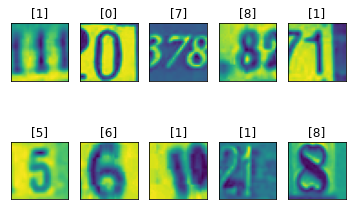

In [21]:
# Ploting the Grayscale Image after normalization
plot_images(train_grayscale, train_labels)

Deleting unused variables to clear RAM

In [0]:
# Deleting unused variables to free RAM
del train_images, test_images
del train, test

# Deleting extra grayscale variables
del train_grayscale, test_grayscale, val_grayscale

In [23]:
print(f"Training Images : 'train_imgs' , Testing Images : 'test_imgs' , Validation Images : 'val_imgs'")
print(f"Training labels : 'train_imgs' , Testing labels : 'test_imgs' , Validation labels : 'val_imgs'")

Training Images : 'train_imgs' , Testing Images : 'test_imgs' , Validation Images : 'val_imgs'
Training labels : 'train_imgs' , Testing labels : 'test_imgs' , Validation labels : 'val_imgs'


## 2. MLP Neural Network Designed


Function to test accuarcy and loss of model

In [0]:
# To get model accuracy and loss

def test_model(model, x_test, y_test):
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
    
    print(f'Test Accuracy: {test_acc:0.3f}')
    print(f'Test Loss : {test_loss:0.3f}')

Function to create and compile a MLP Sequential model

In [0]:
def get_mlp_model(shape):
    # Returns a MLP model
    model = Sequential([
        Flatten(input_shape=shape),
        Dense(128, activation='relu'),
        Dropout(0.25),
        Dense(128, activation='relu'),
        Dropout(0.25),
        Dense(64, activation='relu'),
        Dropout(0.25),
        Dense(10, activation='softmax')
        ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

Creating a MLP model and prining it's summary

In [34]:
mlp_model = get_mlp_model(train_imgs[0].shape)
mlp_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               131200    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)               

In [36]:
mlp_model.fit(train_imgs, train_labels, epochs= 15, batch_size=6,verbose=1, validation_data=(val_imgs, val_labels))

Epoch 1/15
10989/10989 [==============================] - 41s 4ms/step - loss: 1.3102 - accuracy: 0.5846 - val_loss: 1.0875 - val_accuracy: 0.6649
Epoch 2/15
10989/10989 [==============================] - 41s 4ms/step - loss: 1.2498 - accuracy: 0.6099 - val_loss: 1.0046 - val_accuracy: 0.6949
Epoch 3/15
10989/10989 [==============================] - 42s 4ms/step - loss: 1.1902 - accuracy: 0.6325 - val_loss: 0.9495 - val_accuracy: 0.7209
Epoch 4/15
10989/10989 [==============================] - 42s 4ms/step - loss: 1.1482 - accuracy: 0.6519 - val_loss: 0.9586 - val_accuracy: 0.7128
Epoch 5/15
10989/10989 [==============================] - 42s 4ms/step - loss: 1.1129 - accuracy: 0.6614 - val_loss: 0.9012 - val_accuracy: 0.7290
Epoch 6/15
10989/10989 [==============================] - 41s 4ms/step - loss: 1.0920 - accuracy: 0.6700 - val_loss: 0.9041 - val_accuracy: 0.7295
Epoch 7/15
10989/10989 [==============================] - 41s 4ms/step - loss: 1.0837 - accuracy: 0.6749 - val_loss: 0

In [37]:
# To get testing accuracy and loss before training
test_model(mlp_model, test_imgs, test_labels)

Test Accuracy: 0.712
Test Loss : 0.985


Functions for creating callbacks during model fitting

In [0]:
# Defining callbacks functions

def get_checkpoint_every_epoch(folder):
    # Creates checkpoint for every epoch
    path = 'checkpoints/every_epoch/' + folder
    checkpoint_every_epoch = ModelCheckpoint(filepath=path,
                             frequency='epoch',
                             save_weights_only=True,
                             verbose=0)
    return checkpoint_every_epoch

def get_checkpoint_best_only(folder):
    # Creates checkpoint for best validation accuracy
    path = 'checkpoints/best_only/' + folder + '/checkpoint'
    checkpoints_best_only = ModelCheckpoint(filepath=path,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_accuracy',
                             verbose=0)
    return checkpoints_best_only, path

def get_early_stopping(patience=3):
    # Creates earlystopping callback
    return EarlyStopping(monitor='val_accuracy', patience=patience)


Creating callbacks for MLP model

In [0]:
# Creatinng callbacks objects for MLP model
checkpoint_every_epoch = get_checkpoint_every_epoch('checkpoint_{epoch:03d}')
checkpoint_best_only, mlp_best_path = get_checkpoint_best_only('mlp')
early_stopping = get_early_stopping(5)

callbacks = [checkpoint_every_epoch, checkpoint_best_only, early_stopping]

Training (fitting) MLP model and validating it simultaneously and store it's history

In [43]:
# Fitting the MLP model with callbacks and validation set

mlp_history = mlp_model.fit(train_imgs,
                        train_labels,
                        epochs=30,
                        validation_data=(val_imgs, val_labels),
                        callbacks=callbacks,
                        batch_size=512,
                        verbose=1)

Epoch 1/30
129/129 [==============================] - 1s 6ms/step - loss: 0.7048 - accuracy: 0.7865 - val_loss: 0.6193 - val_accuracy: 0.8194
Epoch 2/30
129/129 [==============================] - 1s 6ms/step - loss: 0.7035 - accuracy: 0.7883 - val_loss: 0.6179 - val_accuracy: 0.8195
Epoch 3/30
129/129 [==============================] - 1s 6ms/step - loss: 0.7031 - accuracy: 0.7890 - val_loss: 0.6159 - val_accuracy: 0.8209
Epoch 4/30
129/129 [==============================] - 1s 6ms/step - loss: 0.6934 - accuracy: 0.7896 - val_loss: 0.6121 - val_accuracy: 0.8209
Epoch 5/30
129/129 [==============================] - 1s 6ms/step - loss: 0.6955 - accuracy: 0.7893 - val_loss: 0.6125 - val_accuracy: 0.8232
Epoch 6/30
129/129 [==============================] - 1s 6ms/step - loss: 0.6957 - accuracy: 0.7906 - val_loss: 0.6094 - val_accuracy: 0.8228
Epoch 7/30
129/129 [==============================] - 1s 6ms/step - loss: 0.6910 - accuracy: 0.7918 - val_loss: 0.6128 - val_accuracy: 0.8187
Epoch 

Functions for plotting Accuracy and Loss using history of model training

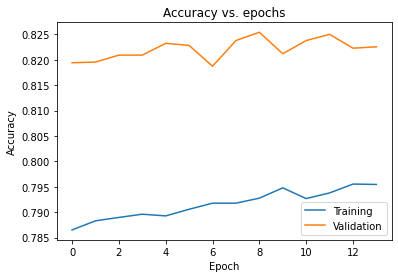

In [44]:
# Plotting the Accuracy graph on history
def plot_accuracy_graph(history):
    try:
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
    except KeyError:
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
    plt.title('Accuracy vs. epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show() 

plot_accuracy_graph(mlp_history)

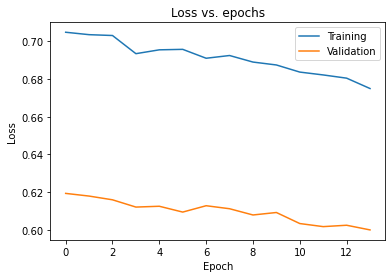

In [45]:
# Plotting the Loss graph from history
def plot_loss_graph(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.show()

plot_loss_graph(mlp_history)

In [46]:
# To find accuracy and loss on testing data after training

test_model(mlp_model, test_imgs,  test_labels)

Test Accuracy: 0.792
Test Loss : 0.707


In [0]:
# Deleting the model to clear RAM

del mlp_model

## 3. CNN neural network classifier

Function to create a CNN model and compile it

In [0]:
def get_cnn_model(shape):
    # Returns CNN model and compiles
    model = Sequential([
                    Conv2D(32, kernel_size=3, activation='relu', padding='SAME', input_shape=shape),
                    BatchNormalization(),
                    Conv2D(32, kernel_size=3, activation='relu', padding='SAME'),
                    BatchNormalization(),
                    MaxPooling2D(2),
                    Dropout(0.3),

                    Conv2D(32, kernel_size=3, activation='relu', padding='SAME'),
                    BatchNormalization(),
                    Conv2D(32, kernel_size=3, activation='relu', padding='SAME'),
                    BatchNormalization(),
                    MaxPooling2D(2),
                    Dropout(0.3),
                    
                    Conv2D(32, kernel_size=3, activation='relu', padding='SAME'),
                    BatchNormalization(),
                    Conv2D(32, kernel_size=3, activation='relu', padding='SAME'),
                    BatchNormalization(),
                    MaxPooling2D(2),
                    Dropout(0.3),
                    
                    Flatten(),
                    Dense(32, activation='relu'),
                    Dropout(0.3),
                    Dense(10, activation='softmax')
            ])
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [50]:
# Get a CNN model and prining it's summary

cnn_model = get_cnn_model(train_imgs[0].shape)
cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)       

In [56]:
# Testing CNN model accuracy and loss before training
cnn_model.fit(train_imgs, train_labels, epochs= 10, batch_size=256,verbose=1, validation_data=(val_imgs, val_labels))
test_model(cnn_model, test_imgs, test_labels)

Epoch 1/10
258/258 [==============================] - 10s 40ms/step - loss: 2.2280 - accuracy: 0.1889 - val_loss: 2.1731 - val_accuracy: 0.1919
Epoch 2/10
258/258 [==============================] - 10s 39ms/step - loss: 2.0362 - accuracy: 0.2353 - val_loss: 1.4958 - val_accuracy: 0.4704
Epoch 3/10
258/258 [==============================] - 10s 39ms/step - loss: 1.5322 - accuracy: 0.4277 - val_loss: 0.8642 - val_accuracy: 0.7411
Epoch 4/10
258/258 [==============================] - 10s 39ms/step - loss: 1.1002 - accuracy: 0.6186 - val_loss: 0.5769 - val_accuracy: 0.8239
Epoch 5/10
258/258 [==============================] - 10s 39ms/step - loss: 0.8179 - accuracy: 0.7321 - val_loss: 0.4711 - val_accuracy: 0.8632
Epoch 6/10
258/258 [==============================] - 10s 39ms/step - loss: 0.6907 - accuracy: 0.7779 - val_loss: 0.3958 - val_accuracy: 0.8836
Epoch 7/10
258/258 [==============================] - 10s 38ms/step - loss: 0.5960 - accuracy: 0.8124 - val_loss: 0.3579 - val_accuracy:

Creating callbacks for CNN model

In [0]:
# Creating callback for CNN model

checkpoint_every_epoch = get_checkpoint_every_epoch('checkpoint_{epoch:03d}')
checkpoint_best_only, cnn_best_path = get_checkpoint_best_only('cnn')
early_stopping = get_early_stopping(5)

callbacks = [checkpoint_every_epoch, checkpoint_best_only, early_stopping]

In [59]:
# Fitting the model with batch size of 512 and validating it simultaneously

cnn_history = cnn_model.fit(train_imgs,
                        train_labels,
                        epochs=50,
                        validation_data=(val_imgs, val_labels),
                        callbacks=callbacks,
                        batch_size=512,
                        verbose=1)

Epoch 1/50
129/129 [==============================] - 9s 71ms/step - loss: 0.4039 - accuracy: 0.8802 - val_loss: 0.2748 - val_accuracy: 0.9197
Epoch 2/50
129/129 [==============================] - 9s 70ms/step - loss: 0.3941 - accuracy: 0.8847 - val_loss: 0.2721 - val_accuracy: 0.9222
Epoch 3/50
129/129 [==============================] - 9s 70ms/step - loss: 0.3802 - accuracy: 0.8885 - val_loss: 0.2655 - val_accuracy: 0.9241
Epoch 4/50
129/129 [==============================] - 9s 70ms/step - loss: 0.3738 - accuracy: 0.8912 - val_loss: 0.2730 - val_accuracy: 0.9211
Epoch 5/50
129/129 [==============================] - 9s 70ms/step - loss: 0.3611 - accuracy: 0.8937 - val_loss: 0.2568 - val_accuracy: 0.9263
Epoch 6/50
129/129 [==============================] - 9s 70ms/step - loss: 0.3529 - accuracy: 0.8980 - val_loss: 0.2561 - val_accuracy: 0.9271
Epoch 7/50
129/129 [==============================] - 9s 69ms/step - loss: 0.3468 - accuracy: 0.8994 - val_loss: 0.2569 - val_accuracy: 0.9257

Plotting Accuracy and Loss graphs from training history of CNN model

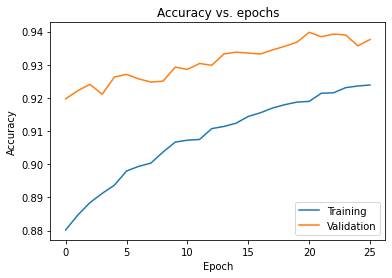

In [60]:
plot_accuracy_graph(cnn_history)

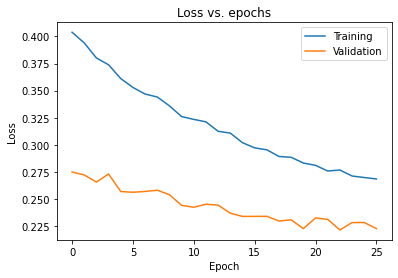

In [61]:
plot_loss_graph(cnn_history)

In [62]:
# Testing CNN model accuracy and loss after training

test_model(cnn_model, test_imgs, test_labels)

Test Accuracy: 0.944
Test Loss : 0.210


In [0]:
# Deleting the model to clear RAM

del cnn_model

## 4. Get model predictions

Checking the location of checkpoint files

In [64]:
! ls -lh checkpoints

total 8.0K
drwxr-xr-x 4 root root 4.0K May 27 07:26 best_only
drwxr-xr-x 2 root root 4.0K May 27 07:30 every_epoch


Creating a new MLP model

In [65]:
new_mlp_model = get_mlp_model(train_imgs[0].shape)
new_mlp_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               131200    
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)               

In [66]:
# Testing model's accuarcy and loss before loading weights

test_model(new_mlp_model, test_imgs, test_labels)

Test Accuracy: 0.069
Test Loss : 2.783


Loading best weights for MLP model and then testing it's accuarcy and loss after loading weights

In [67]:
new_mlp_model.load_weights(mlp_best_path)
test_model(new_mlp_model, test_imgs, test_labels)

Test Accuracy: 0.791
Test Loss : 0.716


Creating new CNN model

In [68]:
new_cnn_model = get_cnn_model(train_imgs[0].shape)
new_cnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 32)       

In [69]:
# Testing CNN model's accuarcy and loss before loading weights

test_model(new_cnn_model, test_imgs, test_labels)

Test Accuracy: 0.113
Test Loss : 2.304


Loading best weights for CNN model and then testing it's accuarcy and loss after loading weights

In [70]:
new_cnn_model.load_weights(cnn_best_path)
test_model(new_cnn_model, test_imgs, test_labels)

Test Accuracy: 0.941
Test Loss : 0.218


In [0]:
# Selecting random images and their labels from testing dataset

num_rows = 5
num_cols = 5

random_slices = np.random.choice(test_imgs.shape[0], num_rows*num_cols)
random_images = test_imgs[random_slices]
random_labels = test_labels[random_slices]

In [0]:
# Converting numpy array to normal list 

random_labels = [[x][0][0] for x in np.ndarray.tolist(random_labels)]

Predicting labels of random images using new CNN model

In [0]:
random_MLP_predictions = new_mlp_model.predict(random_images)
random_CNN_predictions = new_cnn_model.predict(random_images)

Functions to plot predictions with bar graph

In [0]:
def plot_prediction_images(i, predictions_array, true_label, img):
    
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img[:,:,0], cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel(f"True:{true_label} Pred:{predicted_label} with {100*np.max(predictions_array):2.0f}%",color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

In [0]:
# Plotting random images from test dataset, their predicted labels, and the true labels.
# Correct predictions are in blue and incorrect predictions are in red.

def plot_predictions(predictions):
    num_images = num_rows*num_cols

    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    for i in range(num_images):
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_prediction_images(i, predictions[i], random_labels, random_images)
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(i, predictions[i], random_labels)
        
    plt.tight_layout()
    plt.show()

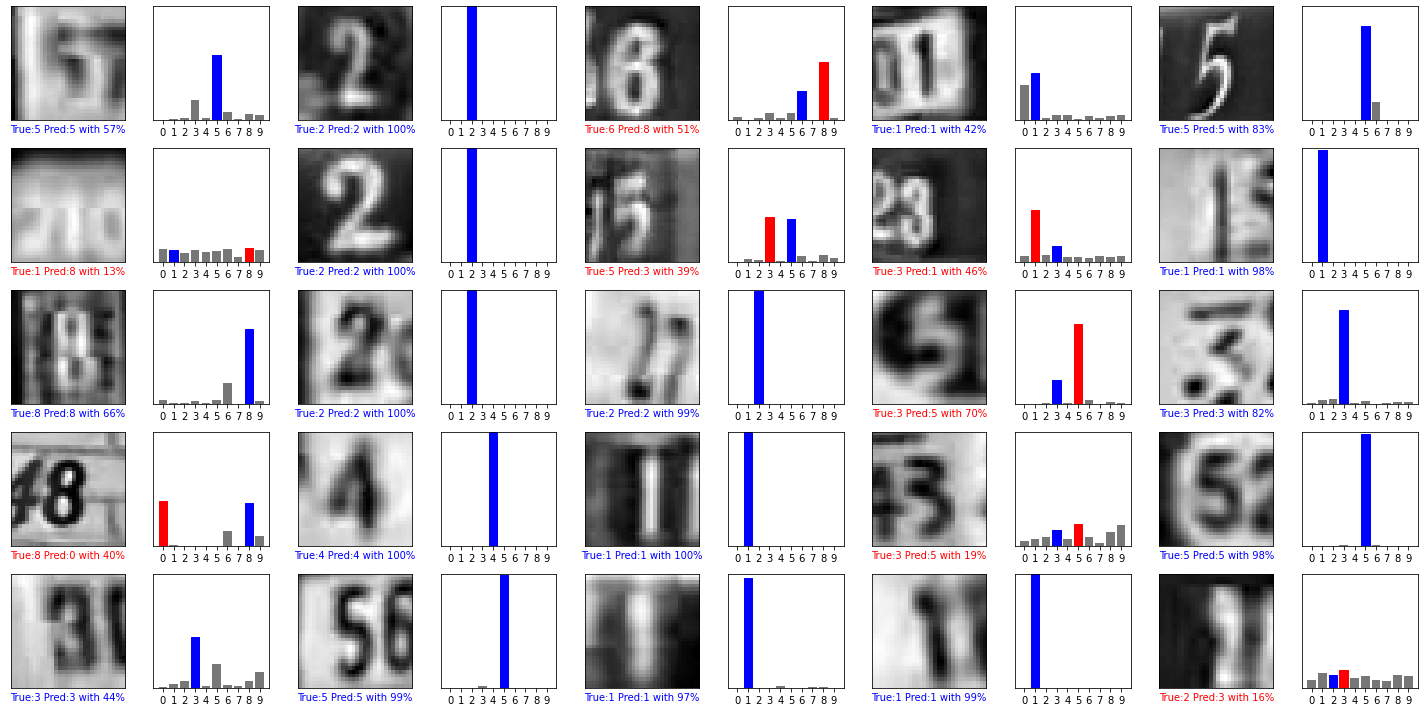

In [76]:
# Plotting MLP predictions

plot_predictions(random_MLP_predictions)

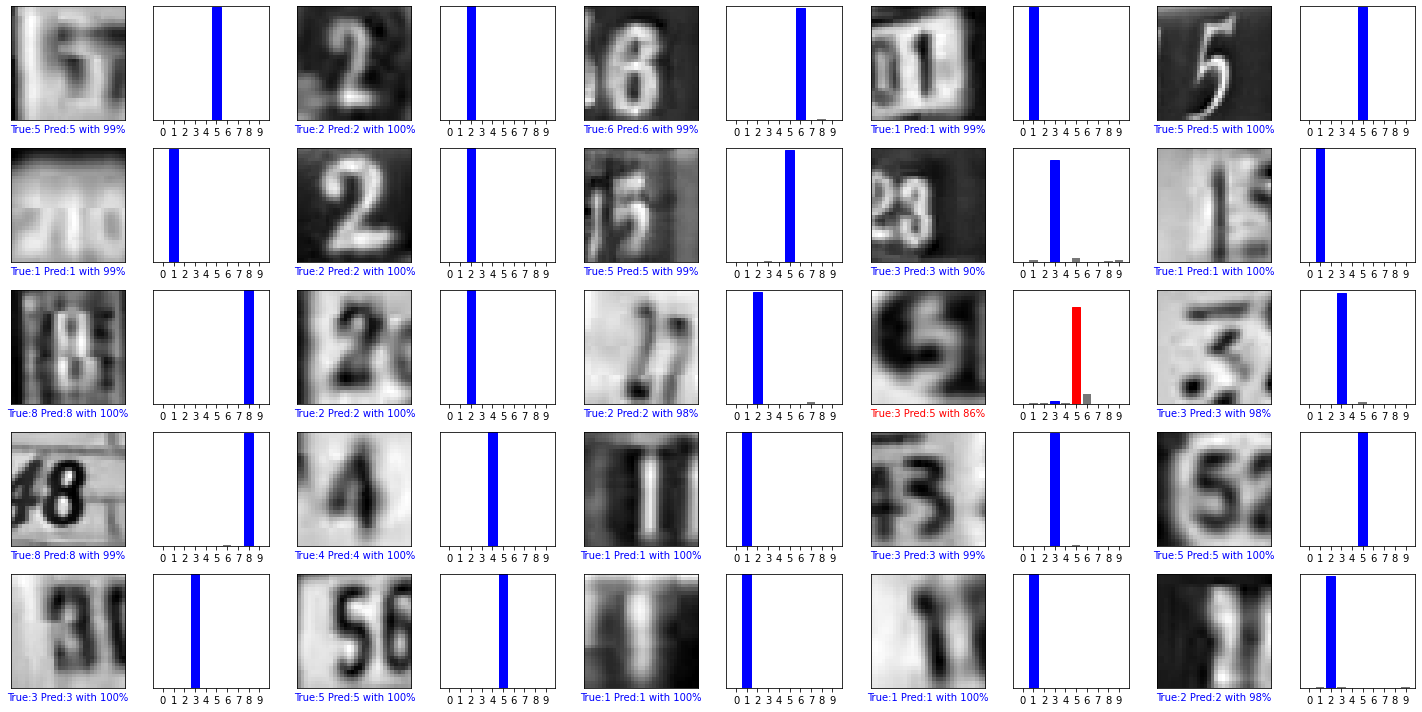

In [77]:
# Plotting CNN predictions

plot_predictions(random_CNN_predictions)